# Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import pandas as pd
import json as js
from zipfile import ZipFile
from collections import Counter
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
import numpy as np



In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [ ]:
zip_file_path = '/content/drive/MyDrive/Workshop_11/FruitsVeggiesData.zip'
  
with ZipFile(zip_file_path, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('/content/drive/MyDrive/Workshop_11/')
    print('Done!')    

In [ ]:
train_dir = '/content/drive/MyDrive/Workshop_11/train'
val_dir = '/content/drive/MyDrive/Workshop_11/train'
test_dir = '/content/drive/MyDrive/Workshop_11/test'
classes0 = os.listdir(train_dir)
classes=sorted(classes0)
print(classes)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [ ]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),              # resize shortest side
        transforms.CenterCrop(40),          # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [ ]:
trainset = ImageFolder(train_dir, transform=train_transform)
valset = ImageFolder(val_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)
print(len(trainset))

3115


# Custom Functions

### Function for the showing the image.

In [ ]:
def show_image(img,label):
    print('Label: ', trainset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

In [ ]:
def process_img(filepath): # passing the filepaths of datasets
    
    labels = [str(filepath[i]).split("/")[-2] #here we are trying to extract the labels for the fruits and veggies by using .split method and
              for i in range(len(filepath))] #since names are secound last word we used [-2] to get that particular name
                  
    filepath = pd.Series(filepath, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label') 
    
    df = pd.concat([filepath, labels], axis=1) 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# EDA

In [ ]:
# view one image shape of the dataset.
img, label = trainset[10]
print(img.shape)

torch.Size([3, 40, 40])


Label:  apple (0)


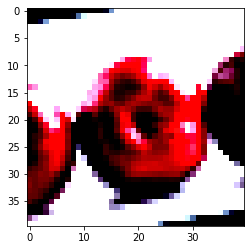

In [ ]:
show_image(*trainset[15])

Label:  carrot (6)


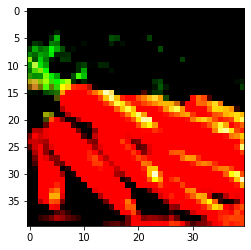

In [ ]:
show_image(*trainset[580])

In [ ]:
from pathlib import Path

train = Path(train_dir) #getting the path of the train dataset
train_filepaths = list(train.glob(r'**/*.jpg')) #glob (short for global) is used to return all file paths that match a specific pattern

valid = Path(val_dir)#for valid dataset
valid_filepaths = list(valid.glob(r'**/*.jpg'))

test = Path(test_dir)#for test dataset
test_filepaths = list(test.glob(r'**/*.jpg'))

In [ ]:
train_df = process_img(train_filepaths) 
valid_df = process_img(valid_filepaths)
test_df = process_img(test_filepaths)

In [ ]:
train_df.head()

FilePath        Label
0  /content/drive/MyDrive/Workshop_11/train/mango...        mango
1  /content/drive/MyDrive/Workshop_11/train/cabba...      cabbage
2  /content/drive/MyDrive/Workshop_11/train/grape...       grapes
3  /content/drive/MyDrive/Workshop_11/train/bell ...  bell pepper
4  /content/drive/MyDrive/Workshop_11/train/tomat...       tomato

In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {len(trainset)}\n')
print(f'Number of different labels: {len(classes)}\n')
print(f'Labels: {set(train_df.Label)}') 

-- Training set --

Number of pictures: 3115

Number of different labels: 36

Labels: {'soy beans', 'raddish', 'peas', 'watermelon', 'carrot', 'chilli pepper', 'lettuce', 'mango', 'eggplant', 'sweetpotato', 'lemon', 'orange', 'bell pepper', 'beetroot', 'banana', 'tomato', 'onion', 'grapes', 'turnip', 'cauliflower', 'capsicum', 'garlic', 'paprika', 'pineapple', 'corn', 'pomegranate', 'apple', 'cucumber', 'pear', 'potato', 'jalepeno', 'spinach', 'cabbage', 'ginger', 'sweetcorn', 'kiwi'}


In [ ]:
print(f'Labels: {set(test_df.Label)}')

Labels: {'soy beans', 'raddish', 'peas', 'watermelon', 'carrot', 'chilli pepper', 'lettuce', 'mango', 'eggplant', 'sweetpotato', 'lemon', 'orange', 'bell pepper', 'beetroot', 'banana', 'tomato', 'onion', 'grapes', 'turnip', 'cauliflower', 'capsicum', 'garlic', 'paprika', 'pineapple', 'corn', 'pomegranate', 'cucumber', 'apple', 'pear', 'potato', 'jalepeno', 'spinach', 'cabbage', 'ginger', 'sweetcorn', 'kiwi'}


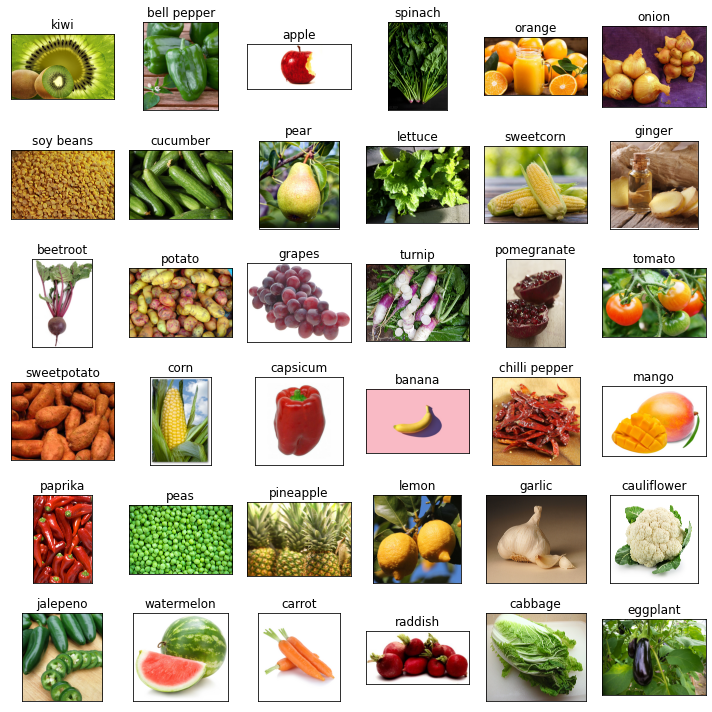

In [ ]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index() #we want to see unique images so we are dropping duplicates and since we dont
                                                                                    #want to mess up the original df we are coping it using .copy()

fig, axes = plt.subplots(6,6, figsize=(10,10),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unique_labels.FilePath[i]))
    ax.set_title(unique_labels.Label[i], fontsize=12)
    
plt.tight_layout()
plt.show()

# Data Preprocessing

In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valid_images = data_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


# Model building

### Mobile Net v2

In [ ]:
base_model =  tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
) #this is our base model 

base_model.trainable = False # we dont want to train the intial weights so we use .trainable = False 

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary() # Lets look at the layers we have in basemodel 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
inputs = base_model.input # this is our input layer which is the base_model's input

x = tf.keras.layers.Dense(128, activation='relu')(base_model.output) #here we passed this base_model.output coz on top of our x layer we want the output(bottom) layer of base_model
x = tf.keras.layers.Dense(256, activation='relu')(x) 

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)# here we have 36 diff classes so we take 36 as output

model = tf.keras.Model(inputs=inputs, outputs=outputs) # we are passing in our inputs and outputs to our model now

model.compile(                                           #lets just compile everthing together 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(                    #fit the model 
    train_images,
    validation_data=valid_images,
    batch_size = 32,
    epochs=5,
    callbacks=[                   #we are using callbacks for early stopping in case our model doesn't show any improvement after 2 epochs monitoring the monitering the validation loss
        tf.keras.callbacks.EarlyStopping(  
            monitor='val_loss',
            patience=2,
            restore_best_weights=True #it literally means wat u think (simpleeeeee)
        )
    ]
)

Epoch 1/5
 2/87 [..............................] - ETA: 3:55 - loss: 3.6940 - accuracy: 0.0312 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


87/87 [==============================] - 411s 5s/step - loss: 1.6977 - accuracy: 0.5421 - val_loss: 0.6299 - val_accuracy: 0.8000
Epoch 2/5
87/87 [==============================] - 365s 4s/step - loss: 0.5575 - accuracy: 0.8191 - val_loss: 0.3608 - val_accuracy: 0.8899
Epoch 3/5
87/87 [==============================] - 360s 4s/step - loss: 0.3339 - accuracy: 0.8896 - val_loss: 0.1967 - val_accuracy: 0.9475
Epoch 4/5
87/87 [==============================] - 369s 4s/step - loss: 0.2101 - accuracy: 0.9266 - val_loss: 0.1383 - val_accuracy: 0.9647
Epoch 5/5
87/87 [==============================] - 361s 4s/step - loss: 0.1552 - accuracy: 0.9514 - val_loss: 0.1033 - val_accuracy: 0.9673


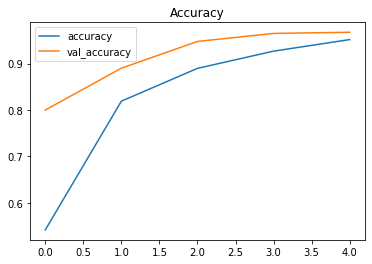

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()  # we are plotting the train and validation accuracy to check on if its overfitting 
plt.title('Accuracy')
plt.x
plt.show()

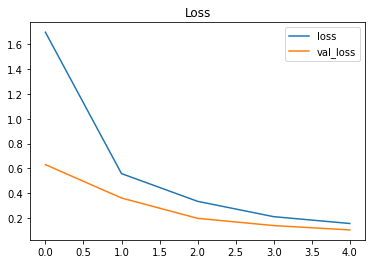

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

In [ ]:
pred = model.predict(test_images) #its predicting time , our model will try to predict the prob of the particular class 
pred = np.argmax(pred, axis=1) # we are seeing the highest prob value and taking the index of it  

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/11 [==============================] - 30s 3s/step


In [ ]:
labels = (train_images.class_indices) #this gives us the labels with indicies to map
labels

In [ ]:
labels = dict((v,k) for k,v in labels.items()) 
pred = [labels[k] for k in pred] #we are iterating over the pred and taking the label for that particualar value

y_test = [labels[k] for k in test_images.classes]  #we are taking labels for test images 

In [ ]:
from sklearn.metrics import accuracy_score # Lets see how well our model is performing 
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

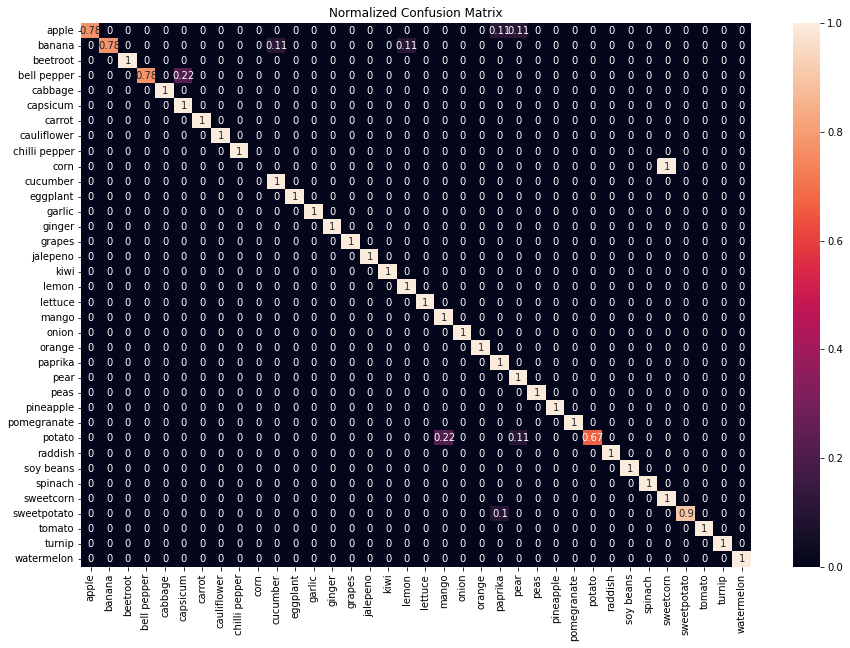

In [ ]:
from sklearn.metrics import confusion_matrix #lets visualise the model predictions 
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')  
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)), #we put this to see labels
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()

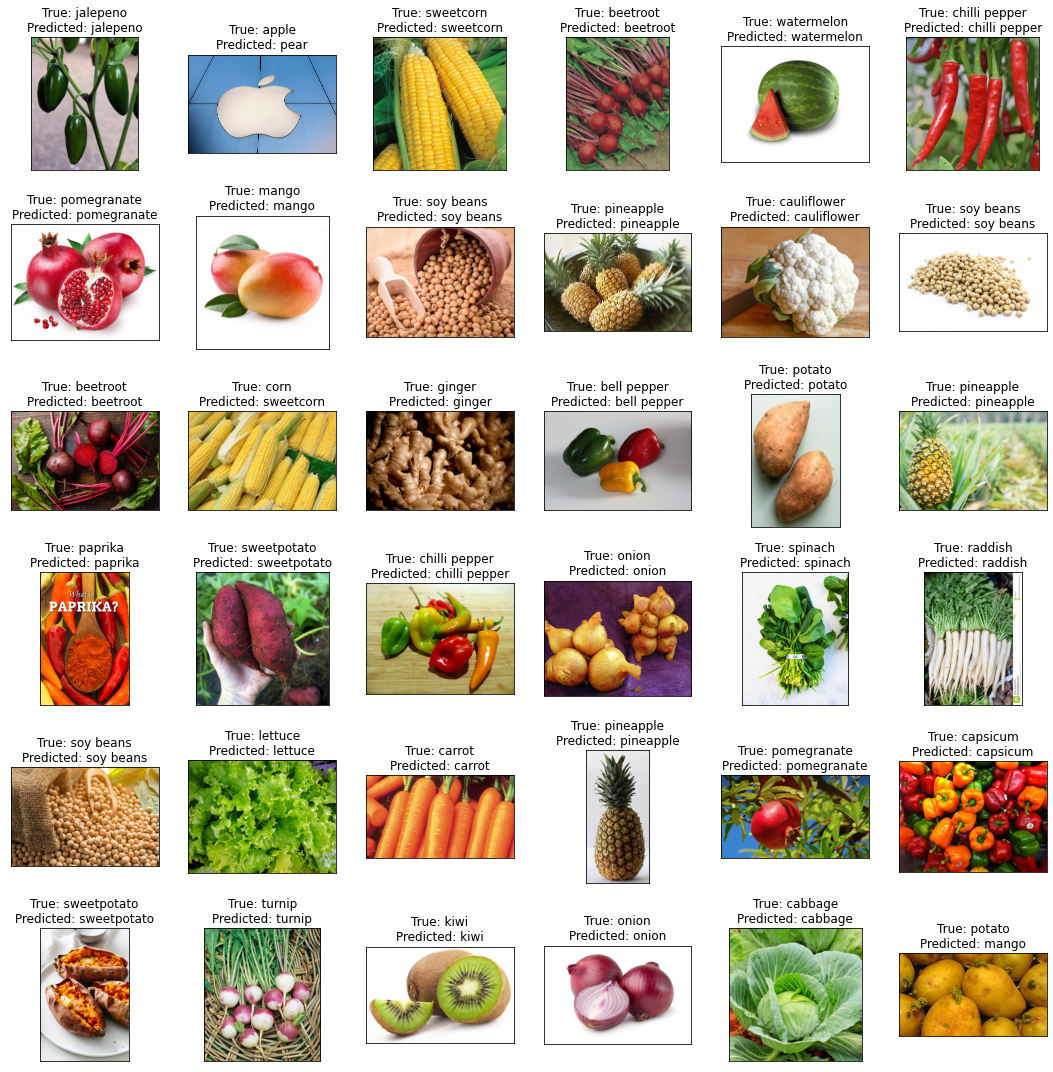

In [ ]:
fig, axes = plt.subplots(6,6,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []}) #will see the actual and predicted labels with images.

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.FilePath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# Lenet

In [ ]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valid_images = data_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

NameError: ignored

In [ ]:
lenet_5_model = tf.keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=(224,224,1), padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C5
    keras.layers.Flatten(), #Flatten    
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(36, activation='softmax') #Output layer
])

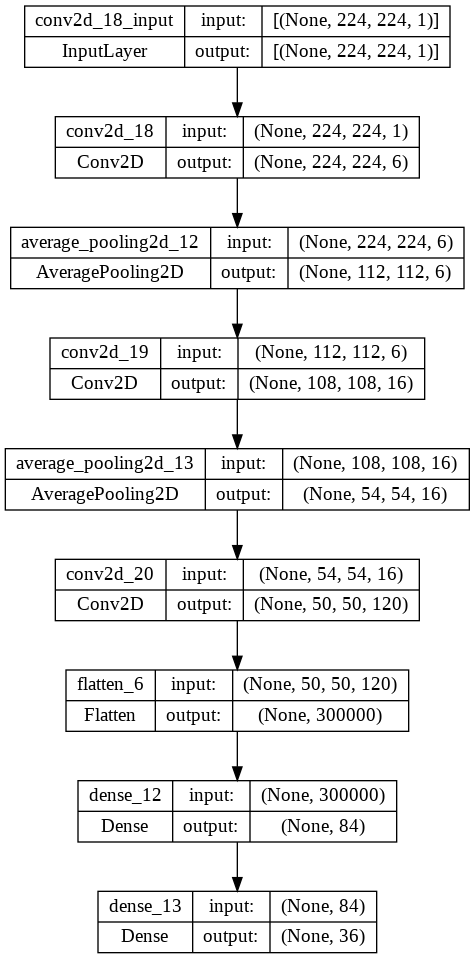

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(lenet_5_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
lenet_5_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
lenet_5_model.fit(train_images,
    validation_data=valid_images,
    batch_size = 32,
    epochs=5,   
     callbacks=[                   #we are using callbacks for early stopping in case our model doesn't show any improvement after 2 epochs monitoring the monitering the validation loss
        tf.keras.callbacks.EarlyStopping(  
            monitor='val_loss',
            patience=2,
            restore_best_weights=True #it literally means wat u think (simpleeeeee)
        )
    ]
    )

Epoch 1/5
15/87 [====>.........................] - ETA: 4:06 - loss: 4.0039 - accuracy: 0.0542

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


87/87 [==============================] - 457s 5s/step - loss: 3.6774 - accuracy: 0.0612 - val_loss: 3.3093 - val_accuracy: 0.1302
Epoch 2/5
87/87 [==============================] - 447s 5s/step - loss: 3.0045 - accuracy: 0.2047 - val_loss: 2.2978 - val_accuracy: 0.4450
Epoch 3/5
87/87 [==============================] - 444s 5s/step - loss: 2.1718 - accuracy: 0.4622 - val_loss: 1.3859 - val_accuracy: 0.7158
Epoch 4/5
87/87 [==============================] - 435s 5s/step - loss: 1.3658 - accuracy: 0.7162 - val_loss: 0.8332 - val_accuracy: 0.8860
Epoch 5/5
87/87 [==============================] - 444s 5s/step - loss: 0.7732 - accuracy: 0.8806 - val_loss: 0.4759 - val_accuracy: 0.9522


In [ ]:
history = lenet_5_model.history

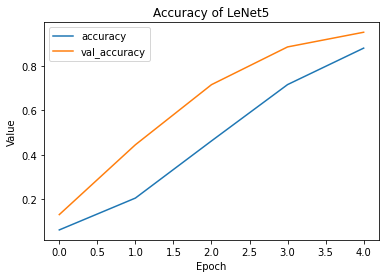

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()  # we are plotting the train and validation accuracy to check on if its overfitting 
plt.title('Accuracy of LeNet5')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

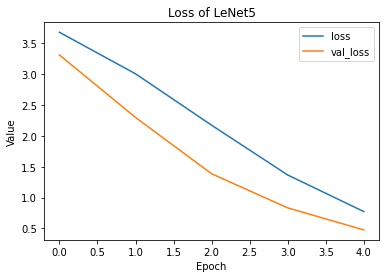

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss of LeNet5')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

In [ ]:
pred = lenet_5_model.predict(test_images) #its predicting time , our model will try to predict the prob of the particular class 
pred = np.argmax(pred, axis=1) # we are seeing the highest prob value and taking the index of it  

 6/11 [===============>..............] - ETA: 55s 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/11 [==============================] - 104s 10s/step


Accuracy on the test set: 92.81%


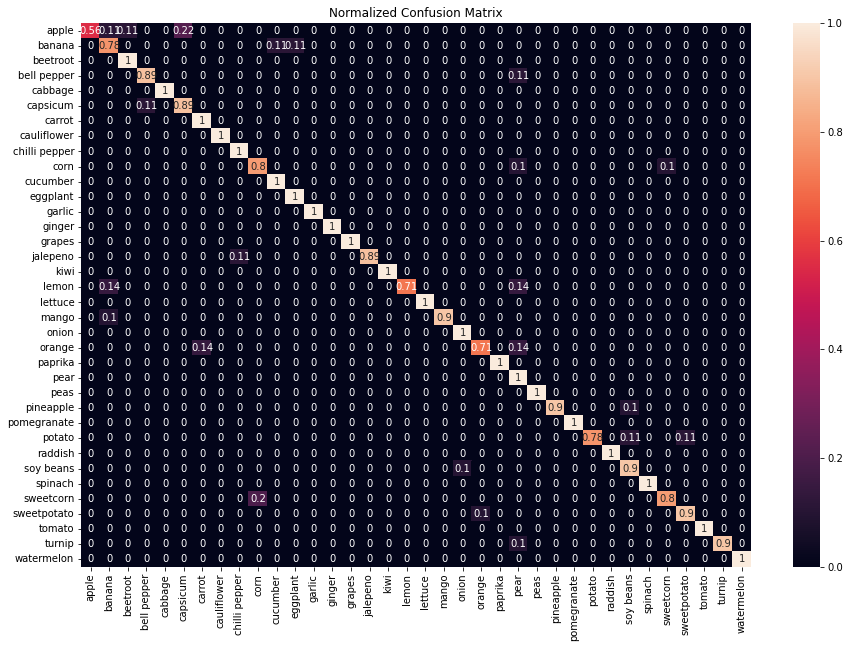

In [ ]:
from sklearn.metrics import accuracy_score # Lets see how well our model is performing 
from sklearn.metrics import confusion_matrix #lets visualise the model predictions 
import seaborn as sns

labels = (train_images.class_indices) #this gives us the labels with indicies to map
labels
labels = dict((v,k) for k,v in labels.items()) 
#pred = [labels[k] for k in pred] #we are iterating over the pred and taking the label for that particualar value
y_test = [labels[k] for k in test_images.classes]  #we are taking labels for test images 

acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

cf_matrix = confusion_matrix(y_test, pred, normalize='true')  
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)), #we put this to see labels
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()


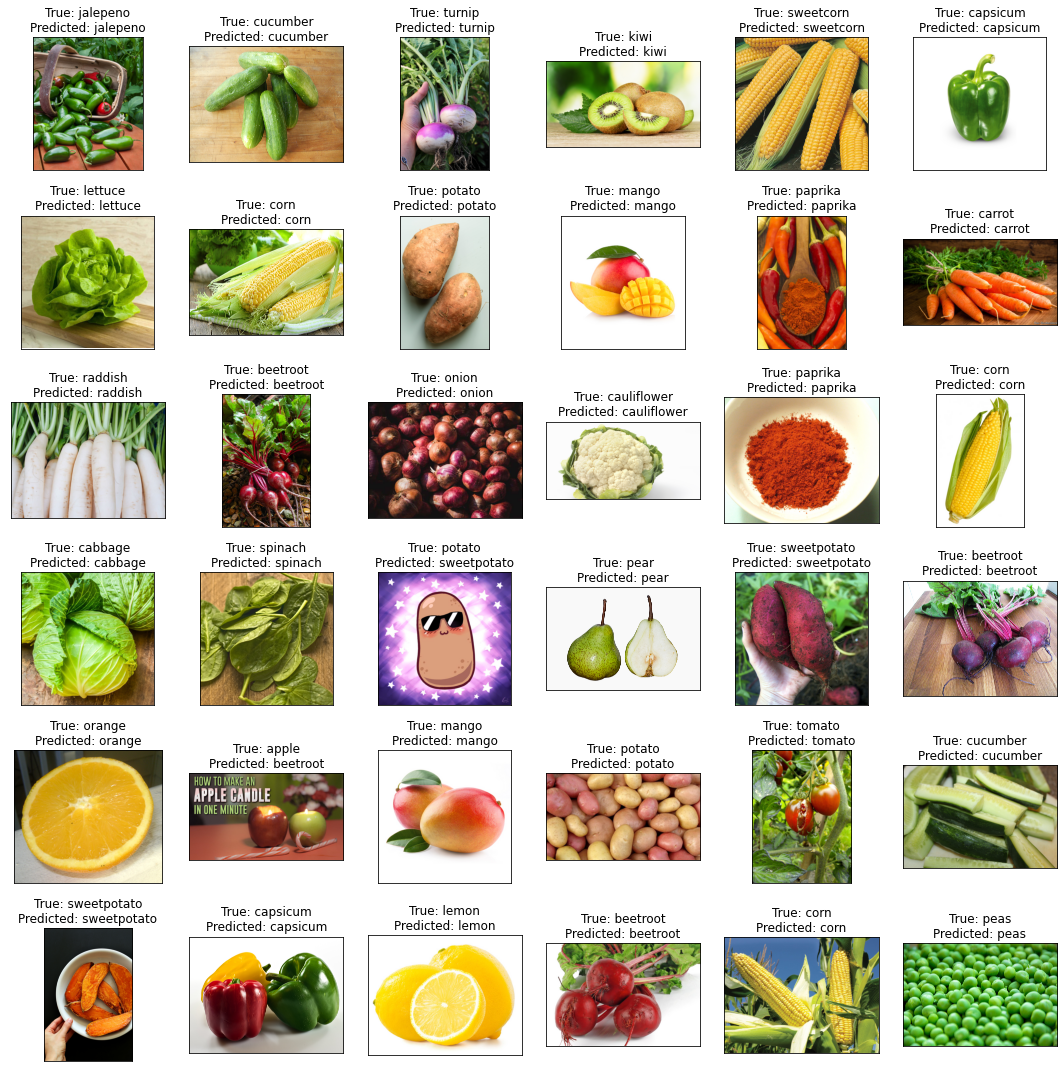

In [ ]:
fig, axes = plt.subplots(6,6,figsize=(15,15), subplot_kw={'xticks': [], 'yticks': []}) #will see the actual and predicted labels with images.

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.FilePath.iloc[i]), cmap='gray')
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()